# Ad Segment Classification with Deep Learning
Cody Pumper, MSDS Candidate

Repository: https://github.com/codiak/DTSA-5798-Article-Classifier

*Professor Chris Vargo, DTSA 5798 Supervised Text Classification*

## Overview

This notebook encompasses the EDA, model training, and validation for a binary classifier using ktrain against a HuffPost article dataset. In this project, I am developing a model for a hypothetical media buying company, to develop a deep learning algorithm for their new client, Theragun. Theragun specializes in products that appeal to health and wellness enthusiasts, and they wish to target their advertisements on web pages that prominently feature health and wellness news.

The goal is to build a model that can predict the probability that a given news story is about health and wellness. To achieve this, I will test variations on the model, including using DistilBERT versus BERT as the base model, and experimenting with increasing the size of the n-grams. This notebook steps through the process of creating a replicable model, tuning hyperparameters, and evaluating its performance. By the end, we aim to provide Theragun with a robust tool for effective contextual advertising.

### Imports and Requirements

In [ ]:
!pip install tf_keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = 'True'
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
import ktrain
import pandas as pd
import numpy as np

In [2]:
# check for GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun  6 22:56:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   41C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load Data

The HuffPost article dataset is a collection of metadata for articles spanning 2013 to 2018. While it does not include the full article text, the headline and description should provide sufficient context. It was provided to the class as in JSON format, and can be found in this project's repository.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
reviews = pd.read_json("/content/drive/MyDrive/MSDS_marketing_text_analytics/article_categories.json")

In [5]:
reviews.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


## Exploratory Data Analysis

The initial exploration of the data focuses on identifying cardinality and balance of the positive samples which are categorized either "WELLNESS" or "HEALTHY LIVING".

In [ ]:
reviews['category'].value_counts()

category
POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: c

With counts ranging from 1004 to 32,739, we can see the dataset skews heavily towards samples from the "Politics" category, which makes sense given HuffPost's coverage. There are a large number of categories, and quite a few articles to represent each. The target categories include 17,827 articles and 6,694 articles, which is enough for us to produce a successful deep learning model.

In [6]:
reviews['health-wellness'] = np.where(reviews['category'].isin(['HEALTHY LIVING', 'WELLNESS']), 1, 0)
reviews['health-wellness'].describe()

count    200853.000000
mean          0.122084
std           0.327384
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: health-wellness, dtype: float64

Since this project is focusing on identifying health or wellness articles, I have added a column to represent the response as 1 or 0, 1 being a positive sample.

Based on the distribution of this column, our dataset includes about 12% positive examples and 88% negative examples. I will later balance this for quicker training and to avoid skewing the evaluation metrics such as accuracy.

### Checking for potential data cleaning

In [ ]:
reviews.isnull().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
health-wellness      0
dtype: int64

In [ ]:
reviews['short_description'].str.len().describe()

count    200853.000000
mean        114.312686
std          82.288156
min           0.000000
25%          57.000000
50%         120.000000
75%         133.000000
max        1472.000000
Name: short_description, dtype: float64

There are no concerning null values to handle. Looking at one of the text columns which will be a strong feature, "short_description" can very dramatically in length! It might be best to trim the outliers reaching 1,472 chars.

<Axes: xlabel='year'>

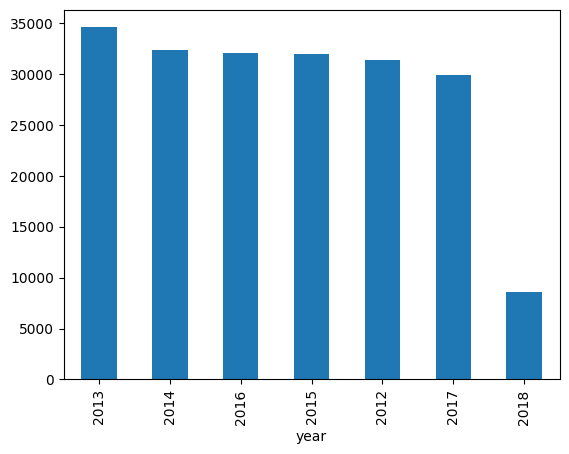

In [ ]:
reviews['year'] = pd.to_datetime(reviews['date']).dt.year
reviews['year'].value_counts().plot(kind='bar')

Looking at the distribution of when the articles were published is useful for understanding the context of the data. In terms of productionizing and using the model developed here, there might be issues with data drift when working with current article metadata, as the data we are training one is 5+ years old.

## Data Preprocessing

The text needs to be processed into tokens that are usable by a model. To do this, I will be using a convenience function from Ktrain that prepares the text based on the target model.

In [ ]:
reviews[reviews['health-wellness'] == 1].count()

category             24521
headline             24521
authors              24521
link                 24521
short_description    24521
date                 24521
health-wellness      24521
dtype: int64

Sampling the data in order to balance the dataset, and reduce the size.

In [7]:
sample_amount = 10000
positive = reviews[reviews['health-wellness'] == 1].sample(n=sample_amount)
negative = reviews[reviews['health-wellness'] == 0].sample(n=sample_amount)
reviews_subset = pd.concat([positive,negative])
# shuffle after concatenating
reviews_subset = reviews_subset.sample(frac=1).reset_index(drop=True)

Prepare the text for Distillbert tokenization.

In [8]:
# Include headline, and trim excessively long descriptions
# Truncate 'short_description' to be no longer than 512 characters
reviews_subset['short_description'] = reviews_subset['short_description'].str.slice(0, 512)
reviews_subset['text'] = reviews_subset['headline'] + ' ' + reviews_subset['short_description']

In [ ]:
train, val, preprocess = ktrain.text.texts_from_df(
    reviews_subset,
    "text",
    label_columns=["health-wellness"],
    val_df=None,
    max_features=20000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",
    verbose=1
)

['not_health-wellness', 'health-wellness']
       not_health-wellness  health-wellness
19564                  0.0              1.0
5143                   0.0              1.0
9432                   1.0              0.0
3715                   1.0              0.0
20                     0.0              1.0
['not_health-wellness', 'health-wellness']
       not_health-wellness  health-wellness
10308                  1.0              0.0
16542                  1.0              0.0
17624                  0.0              1.0
6781                   1.0              0.0
14542                  0.0              1.0


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


In [ ]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=64)

In [ ]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
562/562 [==============================] - 271s 402ms/step - loss: 0.6333 - accuracy: 0.6753
Epoch 2/6
562/562 [==============================] - 229s 408ms/step - loss: 0.2759 - accuracy: 0.8926
Epoch 3/6
562/562 [==============================] - 228s 406ms/step - loss: 0.3333 - accuracy: 0.8414
Epoch 4/6
562/562 [==============================] - 227s 404ms/step - loss: 0.6997 - accuracy: 0.4983
Epoch 5/6
562/562 [==============================] - 226s 401ms/step - loss: 0.6968 - accuracy: 0.4952
Epoch 6/6
562/562 [==============================] - 58s 102ms/step - loss: 920.1299 - accuracy: 0.4991


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


### Determing Learning Rate

The function "lr_find" is used to search for an efficient learning rate. Since the models developed here are similar, I will use this as a baseline rate across all three.

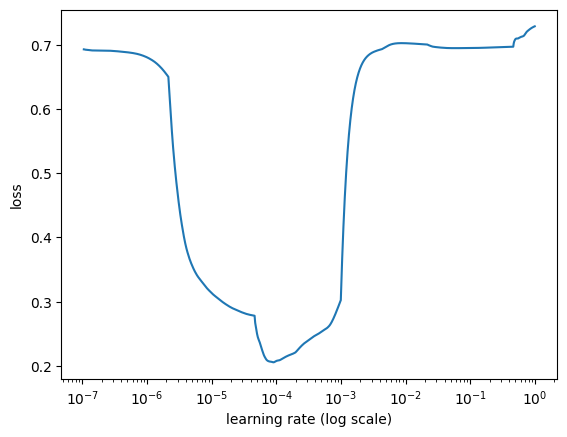

In [ ]:
learner.lr_plot()

In [ ]:
history=learner.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
282/282 [==============================] - 252s 810ms/step - loss: 0.2915 - accuracy: 0.8840 - val_loss: 0.2237 - val_accuracy: 0.9080
Epoch 2/10
282/282 [==============================] - 221s 784ms/step - loss: 0.1403 - accuracy: 0.9499 - val_loss: 0.2275 - val_accuracy: 0.9115
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

In [ ]:
validation = learner.validate(val_data=val, print_report=True)

63/63 [==============================] - 6s 40ms/step
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       979
           1       0.90      0.92      0.91      1021

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



Save model for reproducibility and use:

In [ ]:
predictor.save('/content/drive/MyDrive/MSDS_marketing_text_analytics/model-1-distilbert')

## Training Efficiency and Hardware

Training efficiency is about more than just patience, being able to train a full model in a manageable amount of time on accessible hardware makes replication more accessible and allows for more iteration on the model

The initial configuration using the unbalanced dataset with 200,853 samples on a T4 GPU resulted in ~3 hours of training per epoch, which would take a full day to complete training. Ultimately it was killed by Google Colab for running too long:

![image](https://github.com/codiak/DTSA-5798-Article-Classifier/blob/main/T4-full-data.png?raw=t)


The balanced dataset with 24,521 samples per category (49,042 total) training on an L4 GPU performed better, mostly due to the reduction in the dataset. It was taking about 25min per epoch:

![image](https://github.com/codiak/DTSA-5798-Article-Classifier/blob/main/L4-49k-data.png?raw=t)


Finally, a combination of selecting 10,000 samples per category, training on an A100 GPU, and increasing batch size to 64 resulted in a manageable 3-4min per epoch.

## Model B: Bert as Base Model

In the first model, the base model used was DistilBERT, and the text was preprocessed accordingly.

During inference, DistilBERT is 60% faster than BERT. DistilBERT has 44M fewer parameters and in total is 40% smaller than BERT. However, the original BERT model is slightly more performant, and we can test if that performance is meaningful in this case.

In [ ]:
# release GPU memory for next training
ktrain.release_gpu_memory()

In [ ]:
train_bert, val_bert, preprocess_bert = ktrain.text.texts_from_df(
    reviews_subset,
    "text",
    label_columns=["health-wellness"],
    val_df=None,
    max_features=20000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="bert",
    verbose=1
)

['not_health-wellness', 'health-wellness']
       not_health-wellness  health-wellness
13205                  1.0              0.0
9977                   0.0              1.0
17191                  1.0              0.0
8294                   1.0              0.0
7482                   0.0              1.0
['not_health-wellness', 'health-wellness']
       not_health-wellness  health-wellness
13581                  0.0              1.0
19951                  1.0              0.0
2255                   1.0              0.0
4410                   0.0              1.0
3895                   0.0              1.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [ ]:
model_bert = ktrain.text.text_classifier(name='bert', train_data=train_bert, preproc=preprocess_bert)
learner_bert = ktrain.get_learner(model_bert, train_data=train_bert, val_data=val_bert, batch_size=16)

Is Multi-Label? False
maxlen is 512


/usr/local/lib/python3.10/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


done.


/usr/local/lib/python3.10/dist-packages/ktrain/__init__.py:100: UserWarning: For a GPU with 12GB of RAM, the following maxima apply:
        sequence len=64, max_batch_size=64
        sequence len=128, max_batch_size=32
        sequence len=256, max_batch_size=16
        sequence len=320, max_batch_size=14
        sequence len=384, max_batch_size=12
        sequence len=512, max_batch_size=6

        You've exceeded these limits.
        If using a GPU with <=12GB of memory, you may run out of memory during training.
        If necessary, adjust sequence length or batch size based on above.
  I.warnings.warn(msg)


In [ ]:
history_bert = learner_bert.autofit(
    1e-4,
    checkpoint_folder='checkpoint_b',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
1125/1125 [==============================] - 607s 498ms/step - loss: 0.2902 - accuracy: 0.8804 - val_loss: 0.2100 - val_accuracy: 0.9150
Epoch 2/10
1125/1125 [==============================] - 551s 490ms/step - loss: 0.1618 - accuracy: 0.9394 - val_loss: 0.2351 - val_accuracy: 0.9150
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


In [ ]:
predictor_bert = ktrain.get_predictor(learner_bert.model, preproc=preprocess_bert)
validation_bert = learner_bert.validate(val_data=val_bert, print_report=True)

63/63 [==============================] - 26s 282ms/step
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       965
           1       0.90      0.94      0.92      1035

    accuracy                           0.92      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.92      0.92      0.91      2000



In [ ]:
predictor_bert.save('/content/drive/MyDrive/MSDS_marketing_text_analytics/model-2-bert')

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Swapping from DistilBERT to BERT did improve performance! But only by 0.01 in the weighted average for precision and for recall.

The first model took 7.8 min total training time, at about 4min per epoch. In contrast, using BERT as base resulted in 19.3min total training time, at about 10min per epoch. The extra complexity and size of BERT provides a marginal performance bump, but disproportionately increases training time.

## Alternate Preprocessing: Larger N-grams, Less Text

For the third variant, I expanded the text representation to include up to trigrams (3-grams) to capture more contextual information from the text. To accommodate for the increased number of features resulting from the inclusion of trigrams, I increased the `max_features` parameter, ensuring that the model can handle a larger vocabulary size effectively. Additionally, recognizing that the expanded feature space might lead to more complex training dynamics, I decreased the learning rate to help the model converge more smoothly and prevent potential issues with overshooting during optimization.

In [ ]:
train_data_c, val_data_c, preprocess_c = ktrain.text.texts_from_df(
    reviews_subset,
    "text",
    label_columns=["health-wellness"],
    val_df=None,
    max_features=40000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=3,
    preprocess_mode="distilbert",
    verbose=1
)

model_c = preprocess_c.get_classifier()
learner_c = ktrain.get_learner(model_c, train_data=train_data_c, val_data=val_data_c, batch_size=32)

['not_health-wellness', 'health-wellness']
       not_health-wellness  health-wellness
2946                   1.0              0.0
11011                  0.0              1.0
15720                  0.0              1.0
2801                   1.0              0.0
2618                   1.0              0.0
['not_health-wellness', 'health-wellness']
       not_health-wellness  health-wellness
7006                   0.0              1.0
12141                  0.0              1.0
12898                  0.0              1.0
12166                  1.0              0.0
3500                   0.0              1.0
preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 32
	95percentile : 57
	99percentile : 68


In [ ]:
history_c = learner_c.autofit(
    1e-5,
    checkpoint_folder='checkpoint_larger_ngrams',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 1e-05...
Epoch 1/10
563/563 [==============================] - 259s 418ms/step - loss: 0.3081 - accuracy: 0.8718 - val_loss: 0.2082 - val_accuracy: 0.9240
Epoch 2/10
563/563 [==============================] - 230s 409ms/step - loss: 0.1865 - accuracy: 0.9308 - val_loss: 0.2100 - val_accuracy: 0.9185
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


In [ ]:
predictor_c = ktrain.get_predictor(learner_c.model, preproc=preprocess_c)
validation_c = learner_c.validate(val_data=val_data_c, print_report=True)

63/63 [==============================] - 6s 42ms/step
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1008
           1       0.92      0.93      0.92       992

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



In [ ]:
predictor_c.save('/content/drive/MyDrive/MSDS_marketing_text_analytics/model-3-ngrams')

Comparing metrics to the previous strongest model, based on BERT, there is again a marginal increase in performance, notably across the macro averages, as well as a 0.01 increase in the f1-score. However, unlike the BERT based model, it did not come at the cost of training time. This third model trained in 8.2min, comparable to the first, but still performed better.

## Evaluation

Before comparing validation metrics side-by-side, I took a spot-checking approach to seeing if the model behaviors were logical. And to see where they differed in their predictions.

In [9]:
# Reload models if needed
predictor = ktrain.load_predictor('/content/drive/MyDrive/MSDS_marketing_text_analytics/model-1-distilbert')

In [16]:
predictor_bert = ktrain.load_predictor('/content/drive/MyDrive/MSDS_marketing_text_analytics/model-2-bert')

In [13]:
predictor_c = ktrain.load_predictor('/content/drive/MyDrive/MSDS_marketing_text_analytics/model-3-ngrams')

In [14]:
samples = reviews_subset.sample(10)

# Model A: Distilbert Based
for text in samples['text']:
    probs = predictor.predict(text, return_proba=True)
    print("---------------------------")
    print('The probability this is health/wellness is %s' % probs[1])
    print(text)

---------------------------
The probability this is health/wellness is 0.18700695
North America’s Rarest Wolf Had A Bad Year The Mexican gray wolf population in the United States dropped 12 percent in 2015, with the U.S. Fish and Wildlife Service
---------------------------
The probability this is health/wellness is 0.011720816
Older Trump Voters Say They Oppose Key Elements Of GOP Obamacare Replacement Cutting Medicaid and charging older people more aren't popular moves, according to a new AARP survey.
---------------------------
The probability this is health/wellness is 0.004632367
Phoenix Was Trump Country Long Before Trump Phoenix provides Trump with a home to hard-right racial, anti-immigrant and conspiratorial politics.
---------------------------
The probability this is health/wellness is 0.9750275
3 Ways to Stop Complaining! Because You're Stressing Me Out... While there certainly are uncontrollable parts about life, the reality is that the majority of your life is the direct 

In [17]:
# Model B: Bert Based
for text in samples['text']:
    probs = predictor_bert.predict(text, return_proba=True)
    print("---------------------------")
    print('The probability this is health/wellness is %s' % probs[1])
    print(text)

---------------------------
The probability this is health/wellness is 0.009600028
North America’s Rarest Wolf Had A Bad Year The Mexican gray wolf population in the United States dropped 12 percent in 2015, with the U.S. Fish and Wildlife Service
---------------------------
The probability this is health/wellness is 0.2362621
Older Trump Voters Say They Oppose Key Elements Of GOP Obamacare Replacement Cutting Medicaid and charging older people more aren't popular moves, according to a new AARP survey.
---------------------------
The probability this is health/wellness is 0.0009976566
Phoenix Was Trump Country Long Before Trump Phoenix provides Trump with a home to hard-right racial, anti-immigrant and conspiratorial politics.
---------------------------
The probability this is health/wellness is 0.9749405
3 Ways to Stop Complaining! Because You're Stressing Me Out... While there certainly are uncontrollable parts about life, the reality is that the majority of your life is the direct 

In [15]:
# Model C: Larger N-gram Distilbert
for text in samples['text']:
    probs = predictor_c.predict(text, return_proba=True)
    print("---------------------------")
    print('The probability this is health/wellness is %s' % probs[1])
    print(text)

---------------------------
The probability this is health/wellness is 0.16250975
North America’s Rarest Wolf Had A Bad Year The Mexican gray wolf population in the United States dropped 12 percent in 2015, with the U.S. Fish and Wildlife Service
---------------------------
The probability this is health/wellness is 0.004685606
Older Trump Voters Say They Oppose Key Elements Of GOP Obamacare Replacement Cutting Medicaid and charging older people more aren't popular moves, according to a new AARP survey.
---------------------------
The probability this is health/wellness is 0.004798957
Phoenix Was Trump Country Long Before Trump Phoenix provides Trump with a home to hard-right racial, anti-immigrant and conspiratorial politics.
---------------------------
The probability this is health/wellness is 0.96088505
3 Ways to Stop Complaining! Because You're Stressing Me Out... While there certainly are uncontrollable parts about life, the reality is that the majority of your life is the direct

Across these 10 samples, two contrasts stand out. First, the second model was less certain about the article "Older Trump Voters Say They Oppose Key Elements Of GOP Obamacare..." with a 23% probability that it is health/wellness related, whereas the other two models gave it a \<1% probability. The second model also differed on the first article about wolves, suggesting it was less likely.

Second, while all three models predicted a low probability that the last article "Chloë Sevigny in Proenza Schouler..." was health/wellness, the third larger n-gram model gave a 10x larger probability (2% vs 0.2%), suggesting it associate the stylist topic as more closely related which it might be considered semantically.

### Comparing Evaluation Metrics

To compare the evaluation metrics, graph them side-by-side. Professor Vargo provided metrics for his model, which are included along side these three models.

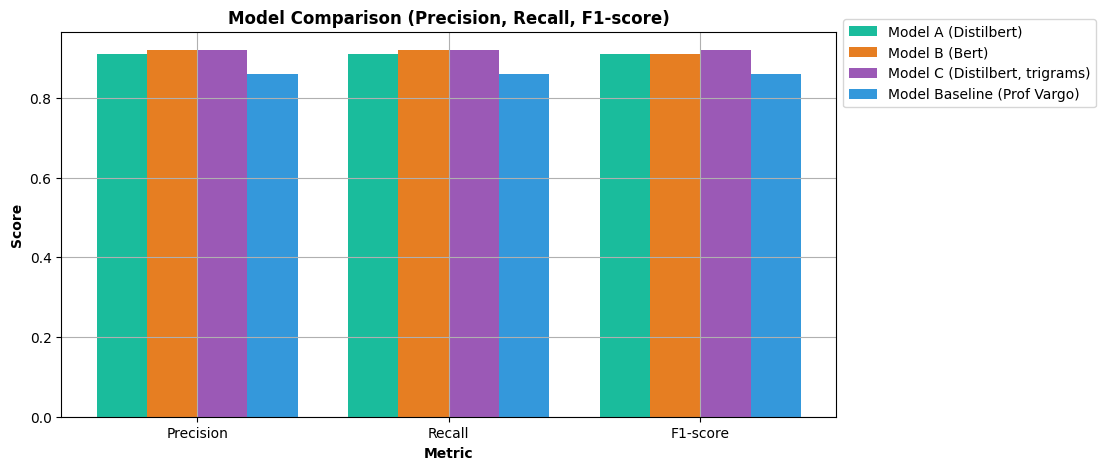

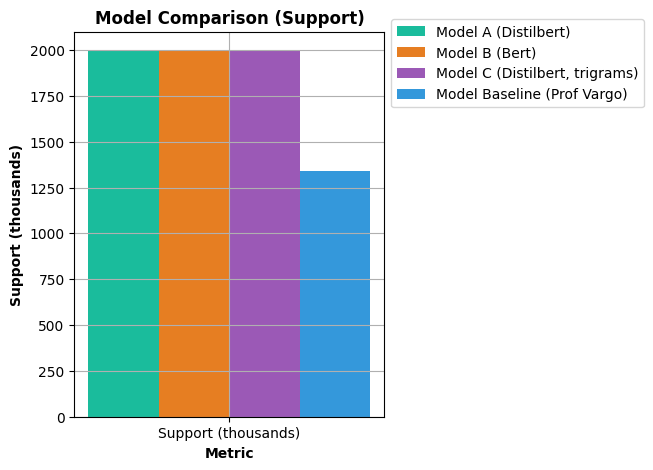

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Static metric variables for reference
categories = ['Precision', 'Recall', 'F1-score']
support_category = ['Support (thousands)']
model_a = [0.91, 0.91, 0.91]
model_b = [0.92, 0.92, 0.91]
model_c = [0.92, 0.92, 0.92]
model_vargo = [0.86, 0.86, 0.86]

support_a = [2000]
support_b = [2000]
support_c = [2000]
support_vargo = [1339]

# Plot to compare metrics
n_categories = len(categories)
bar_width = 0.2
r1 = np.arange(n_categories)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

plt.figure(figsize=(10, 5))
plt.bar(r1, model_a, color='#1abc9c', width=bar_width, label='Model A (Distilbert)')
plt.bar(r2, model_b, color='#e67e22', width=bar_width, label='Model B (Bert)')
plt.bar(r3, model_c, color='#9b59b6', width=bar_width, label='Model C (Distilbert, trigrams)')
plt.bar(r4, model_vargo, color='#3498db', width=bar_width, label='Model Baseline (Prof Vargo)')

# Set up with labels, legend, etc.
plt.xlabel('Metric', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.title('Model Comparison (Precision, Recall, F1-score)', fontweight='bold')
plt.xticks([r + 1.5 * bar_width for r in range(n_categories)], categories)
plt.legend(bbox_to_anchor=(1, 1.05))
plt.grid(True)
plt.show()

# Separate plot for support
plt.figure(figsize=(4, 5))
r1 = np.arange(len(support_category))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

plt.bar(r1, support_a, color='#1abc9c', width=bar_width, label='Model A (Distilbert)')
plt.bar(r2, support_b, color='#e67e22', width=bar_width, label='Model B (Bert)')
plt.bar(r3, support_c, color='#9b59b6', width=bar_width, label='Model C (Distilbert, trigrams)')
plt.bar(r4, support_vargo, color='#3498db', width=bar_width, label='Model Baseline (Prof Vargo)')

plt.xlabel('Metric', fontweight='bold')
plt.ylabel('Support (thousands)', fontweight='bold')
plt.title('Model Comparison (Support)', fontweight='bold')
plt.xticks([r + 1.5 * bar_width for r in range(len(support_category))], support_category)
plt.legend(bbox_to_anchor=(1, 1.05))
plt.grid(True)
plt.show()


## Conclusion

This project explored three different models for classifying HuffPost articles into health and wellness categories for a hypothetical media buying company. The goal was to provide a robust tool for effective contextual advertising, particularly for Theragun, a company targeting health and wellness enthusiasts. I tested three models trained using the Ktrain library: DistilBERT, BERT, and a DistilBERT model with expanded n-grams. Each model was evaluated based on precision, recall, f1-score, and overall training efficiency.

All three models performed well, with accuracy, precision, recall, and f1-scores all around 0.91 to 0.92. The BERT model showed a slight improvement in accuracy and recall compared to DistilBERT, but the performance gain was marginal. Both DistilBERT models  were significantly more efficient in terms of training time. The BERT model required more than double the training time compared to the DistilBERT models, and still *slightly* underperformed the third model.

For future development, given that the training data is 5+ years old, it is crucial to monitor for data drift and regularly update the model with new data to maintain its accuracy. The model developed performs more than well enough for the task at hand, but further fine-tuning of hyperparameters or exploring additional features might also improve performance further.